In [51]:
import os
import torch
import numpy as np
import matplotlib.pyplot as plt

from tqdm import tqdm
from PIL import Image
from torch.utils.data import Dataset
from torchvision.transforms import Resize, Compose, ToTensor

### GTA 5 - DataClass

In [49]:
class GTA5(Dataset):
    def __init__(self, root_dir, split='train'):
        super(GTA5, self).__init__()
        # Save the root directory
        self.root_dir = root_dir
        # Save the split
        self.split = split
        
        # Define the transform for the image and label
        self.transform_image = Compose([
            Resize((256, 256)), 
            ToTensor()
        ])
        self.transform_label = Compose([
            Resize((256, 256))
        ])
        
        # Save image and label paths
        self.image_paths = os.path.join(self.root_dir, 'images')
        self.label_paths = os.path.join(self.root_dir, 'labels')

    def convert_label(self, label):
        label = np.array(label)
        # Iterate over each pixel value and assign 255 if it is not in the labels
        for i in range(label.shape[0]):
            for j in range(label.shape[1]):
                if label[i][j] > 18:
                    label[i][j] = 255
        
        # Return the labels
        return label

    def __getitem__(self, idx):
        # The images and labels should have the same name
        # Each imaage has the following name: 00000.png
        # Each label has the following name: 00000.png
        image_path = os.path.join(self.image_paths, f'{str(idx+1).zfill(5)}.png')
        label_path = os.path.join(self.label_paths, f'{str(idx+1).zfill(5)}.png')

        # Open the image and label
        image = Image.open(image_path)
        label = Image.open(label_path)
        # Apply the transform
        image = self.transform_image(image)
        label = self.transform_label(label)
        # Convert the label to the same format as cityscapes
        label = self.convert_label(label)
        # Transform the label to a tensor
        label = torch.tensor(label).long()
        # Return the image and label
        return image, label

    def __len__(self):
        # Get the number of images
        return len(os.listdir(self.image_paths))


### Example

Number of images: 2500
Shape of the image: torch.Size([3, 256, 256])
Shape of the label: torch.Size([256, 256])


100%|██████████| 2500/2500 [03:36<00:00, 11.54it/s]


Unique labels: {0, 1, 4, 5, 6, 7, 8, 11, 12, 13, 14, 15, 16, 17, 255}


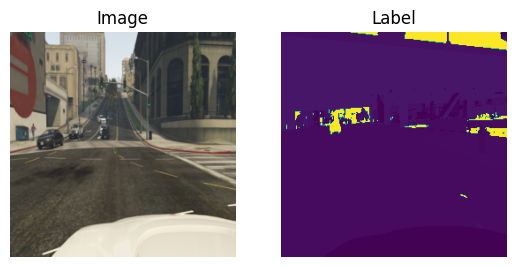

In [50]:
# Create the dataset
dataset = GTA5('GTA5')

# Get the first image and label
image, label = dataset[20]

# Print the number of images
print(f"Number of images: {dataset.__len__()}")

# Print the shape of the image and label
print(f"Shape of the image: {image.shape}")
print(f"Shape of the label: {label.shape}")

# Iterate over the dataset to find all the unique labels
unique_labels = set()
for i in tqdm(range(dataset.__len__())):
    _, label = dataset[i]
    unique_labels.update(np.unique(label))
# Print the unique labels
print(f"Unique labels: {unique_labels}")

# Plot the image and label
plt.subplot(1, 2, 1)
plt.imshow(image.permute(1, 2, 0))
plt.title('Image')
plt.axis('off')
plt.subplot(1, 2, 2)
plt.imshow(label)
plt.title('Label')
plt.axis('off')
plt.show()